In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
import numpy as np
from scipy import stats
import scipy

### Prediction Pipeline Steps
- quadratic fitting: `polyfit`
- transform the data to z-score
- set up the higher boundary and lower boundary. higher is the highest value; lower is the highest value in SNC group
- identify all the overshooting participants

In [2]:
data = pd.read_excel('/Users/yilewang/workspaces/data4project/prediction_project/prediction_data.xlsx', sheet_name='main', skiprows=1)
# drop columns between 33 and 47 in data, Metaconnectivity
# data = data.drop(columns=data.columns[34:47])

In [3]:
## Step 0. Define function
def get_r_squared(x, y, degree=2):
    # Calculate the polynomial
    coefficients = np.polyfit(x, y, degree)
    y_pred = np.polyval(coefficients, x)

    # Calculate the R-squared value
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared, coefficients

def get_z_scores(data):
    return stats.zscore(data)

def get_overshooter(data, cof, start_column=3):
    df_overshooter = pd.DataFrame({'group': data['group'], 'caseid': data['caseid']})
    for cof_indx, i in enumerate(data.columns[start_column:]):
        # in pandas, get the highest value's index
        max_index = data[i].idxmax()
        min_index = data[i].idxmin()
        # get the highest value's index in SNC group
        max_index_SNC = data[data['group'] == 'SNC'][i].idxmax()
        min_index_SNC = data[data['group'] == 'SNC'][i].idxmin()
        # get the high_bound and low_bound
        if cof[cof_indx] > 0:
            high_bound, low_bound = data[i][min_index_SNC], data[i][min_index]
            overshooter = data[(data[i] < high_bound) & (data[i] >= low_bound)]['caseid']
            direction = 'up'
        else:
            high_bound, low_bound = data[i][max_index], data[i][max_index_SNC]
        # get the all the index between the high_bound and low_bound
            overshooter = data[(data[i] <= high_bound) & (data[i] > low_bound)]['caseid']
            direction = 'down'
        df_overshooter[f"{i}_{direction}"] = df_overshooter['caseid'].apply(lambda x: 1 if x in overshooter.values else 0)
    return df_overshooter

def stripplot_get_coordinates(data, x_var, y_var):
    # Demo dataset and apply some culling for visibility

    # Create the stripplot
    ax = sns.stripplot(x=x_var, y=y_var, data=data, jitter=True, dodge=True)

    # Get the coordinates of the points
    coordinates = []
    for collection in ax.collections:
        coordinates.extend(collection.get_offsets())
    return np.array(coordinates)


### Step1. get quadratic list or linear list

In [4]:
pd_zscores = pd.DataFrame()
pd_zscores['group'] = data['group']
pd_zscores['caseid'] = data['caseid']

for i in data.columns[12:]:
    pd_zscores[i] = get_z_scores(data[i])
# pd_zscores.to_excel('/Users/yilewang/workspaces/data4project/prediction_project/prediction_data_zscores.xlsx', index=False)

In [5]:
x = [1,2,3,4]
quadratic_list = []
quadratic_cof = []
linear_list = []
for i in data.columns[12:]:
    # get groupmean 
    groupmean = data.groupby('group')[i].mean()
    linear_fit, _ = get_r_squared(x, groupmean.values, degree=1)
    quadratic_fit,cof = get_r_squared(x, groupmean.values, degree=2)

    if linear_fit <0.9 and quadratic_fit > 0.9:
        print(f"{i}, quadratic: {quadratic_fit}, direction: {cof[0]}, linear: {linear_fit}")
        quadratic_list.append(i)
        quadratic_cof.append(cof[0])

    if linear_fit > 0.8:
        linear_list.append(i)

ignition_mCNG-R, quadratic: 0.9998853437347727, direction: -0.004573829231810269, linear: 0.8203681209956672
ignition_mCNG-L, quadratic: 0.9846960793879252, direction: -0.004301657167555314, linear: 0.8755696429473447
ignition_pCNG-L, quadratic: 0.98978193284399, direction: -0.007151055809701638, linear: 0.6802196585406699
ignition_PHG-L, quadratic: 0.9967020893080583, direction: -0.004329831014976577, linear: 0.8818740090295433
ignition_AMY-R, quadratic: 0.9800417899791182, direction: -0.0042354126198769935, linear: 0.8315836452702177
ignition_AMY-L, quadratic: 0.9683372234583985, direction: -0.004251808918364312, linear: 0.8592194251279999
ignition_sTEMp-R, quadratic: 0.9510548203848984, direction: -0.004589032010878128, linear: 0.7892119974134226
ignition_sTEMp-L, quadratic: 0.9775116060030543, direction: -0.0065602188192951, linear: 0.716064188967652
ignition_mTEMp-R, quadratic: 0.9694387394990174, direction: -0.0050754582226852085, linear: 0.7601128451504472
ignition_mTEMp-L, quad

#### Get the linear list

In [6]:
pd_linear = pd.concat([data['group'], data['caseid'], data[linear_list]], axis=1)
pd_linear.to_excel('/Users/yilewang/workspaces/data4project/prediction_project/linear.xlsx', index=False)

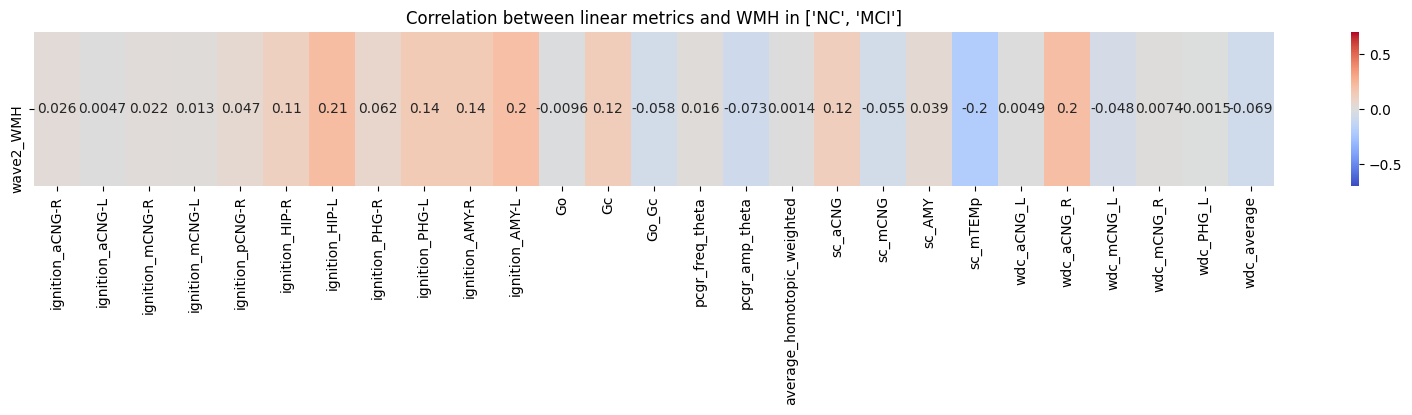

In [7]:
pd_linear_zscores = pd.DataFrame()
pd_linear_zscores['group'] = data['group']
pd_linear_zscores['caseid'] = data['caseid']
pd_linear_zscores['sex'] = data['M_Sex']
for i in pd_linear.columns[2:]:
    pd_linear_zscores[i] = get_z_scores(pd_linear[i])


wmh_wave2 = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='wave2')

common_caseid = pd_linear['caseid'][pd_linear['caseid'].isin(wmh_wave2['M_w2_ID'])]
grouping = [ 'NC', 'MCI']
corr_heatmap = pd.DataFrame()
for i in pd_linear.columns[2:]:
    corr_cof, p = scipy.stats.pearsonr(pd_linear[pd_linear['group'].isin(grouping) & pd_linear['caseid'].isin(common_caseid)].sort_values(by='caseid')[i],wmh_wave2[wmh_wave2['M_w2_group'].isin(grouping)].sort_values(by='M_w2_ID')['M_w2_totalWMH'])
    corr_heatmap.loc[i, 'p_value'] = p
    corr_heatmap.loc[i, 'wave2_WMH'] = corr_cof
for indx, i in enumerate(corr_heatmap.index):
    if corr_heatmap.loc[i, 'p_value'] < 0.05:
        corr_heatmap.loc[i, "sig"] = i + '*'
    else: 
        corr_heatmap.loc[i, "sig"] = i

# plot correlation heatmap
plt.figure(figsize=(20, 2))
sns.heatmap(corr_heatmap.iloc[:,1:2].T, xticklabels= corr_heatmap['sig'], annot=True, cmap='coolwarm', vmin=-0.7, vmax=0.7)
plt.title(f'Correlation between linear metrics and WMH in {grouping}')
plt.show()

### Step2. get quadratic table and the z-score table

In [8]:
pd_quadratic = pd.concat([data['group'], data['caseid'], data[quadratic_list]], axis=1)
# pd_overshoot = get_overshooter(pd_quadratic, cof=quadratic_cof)
# pd_overshoot['sum'] = pd_overshoot[quadratic_list].sum(axis=1)
# pd_overshoot['sex'] = data['M_Sex']
# pd_overshoot.to_excel('/Users/yilewang/workspaces/data4project/overshoot.xlsx', index=False)

In [9]:
pd_quadratic_zscors = pd.DataFrame()
pd_quadratic_zscors['group'] = pd_quadratic['group']
pd_quadratic_zscors['caseid'] = pd_quadratic['caseid']
pd_quadratic_zscors['sex'] = data['M_Sex']
for i in pd_quadratic.columns[2:]:
    z_scores = stats.zscore(pd_quadratic[i])
    pd_quadratic_zscors[i] = z_scores
pd_overshoot = get_overshooter(pd_quadratic_zscors, cof=quadratic_cof)
# pd_overshoot['sum'] = pd_overshoot[pd_overshoot.columns[2:-1]].sum(axis=1)
pd_overshoot['sex'] = data['M_Sex']
# pd_overshoot.to_excel('/Users/yilewang/workspaces/data4project/overshoot.xlsx', index=False)


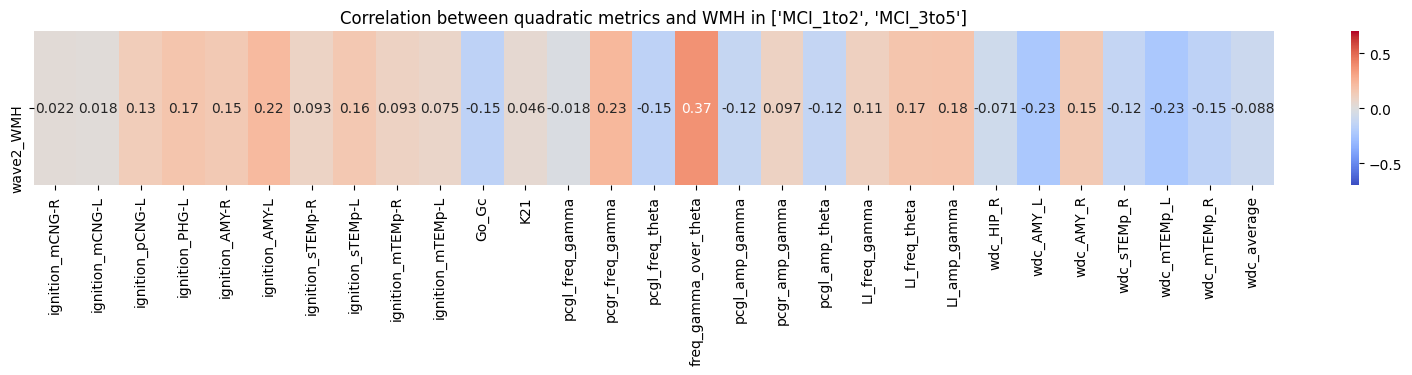

In [10]:
### get the OVER_group comoparison
wmh_wave2 = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='wave2')
wmh_wave2_codes = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='Sheet1')

keys = [ 'MCI_1to2','MCI_3to5']
# keys = ['MCI_0']
OVER_group = wmh_wave2_codes[wmh_wave2_codes['subgroups_1_1'].isin(keys)]['caseid']

corr_heatmap = pd.DataFrame()
comp1 = pd_quadratic[pd_quadratic['caseid'].isin(OVER_group)].sort_values(by='caseid')
comp2 = wmh_wave2_codes[wmh_wave2_codes['caseid'].isin(OVER_group)].sort_values(by='caseid')
for i in pd_quadratic.columns[2:]:
    corr_cof, p = scipy.stats.pearsonr(comp1[i],comp2['M_w2_total_wmh'])
    corr_heatmap.loc[i, 'p_value'] = p
    corr_heatmap.loc[i, 'wave2_WMH'] = corr_cof
for indx, i in enumerate(corr_heatmap.index):
    if corr_heatmap.loc[i, 'p_value'] < 0.05:
        corr_heatmap.loc[i, "sig"] = i + '*'
    else: 
        corr_heatmap.loc[i, "sig"] = i

# plot correlation heatmap
plt.figure(figsize=(20, 2))
sns.heatmap(corr_heatmap.iloc[:,1:2].T, xticklabels= corr_heatmap['sig'], annot=True, cmap='coolwarm', vmin=-0.7, vmax=0.7)
plt.title(f'Correlation between quadratic metrics and WMH in {keys}')
plt.show()

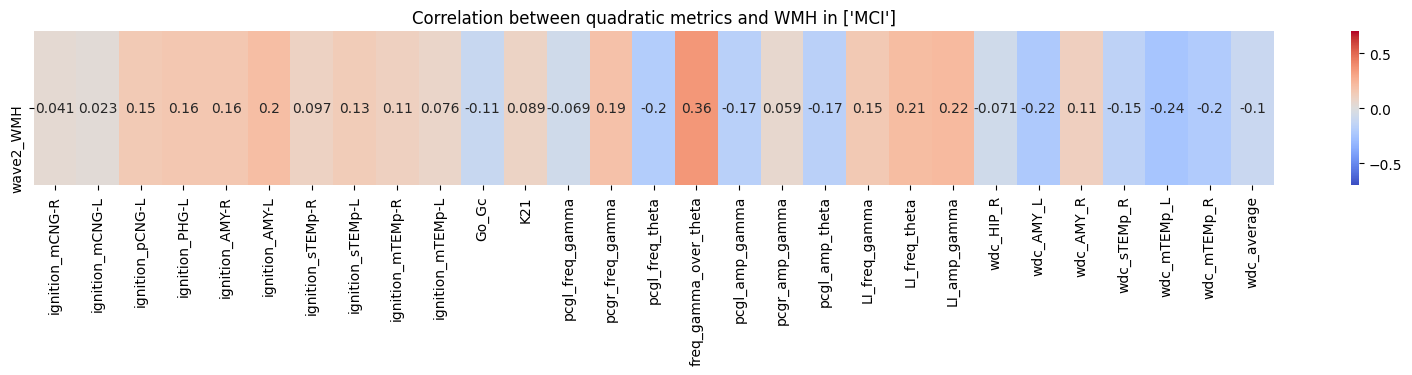

In [11]:
### get NC and MCI group comparison
# find the common caseid between pd_quadratic and wmh_wave2
common_caseid = pd_quadratic['caseid'][pd_quadratic['caseid'].isin(wmh_wave2['M_w2_ID'])]
grouping = [ 'MCI']
corr_heatmap = pd.DataFrame()
for i in pd_quadratic.columns[2:]:
    corr_cof, p = scipy.stats.pearsonr(pd_quadratic[pd_quadratic['group'].isin(grouping) & pd_quadratic['caseid'].isin(common_caseid)].sort_values(by='caseid')[i],wmh_wave2[wmh_wave2['M_w2_group'].isin(grouping)].sort_values(by='M_w2_ID')['M_w2_totalWMH'])
    corr_heatmap.loc[i, 'p_value'] = p
    corr_heatmap.loc[i, 'wave2_WMH'] = corr_cof
for indx, i in enumerate(corr_heatmap.index):
    if corr_heatmap.loc[i, 'p_value'] < 0.05:
        corr_heatmap.loc[i, "sig"] = i + '*'
    else: 
        corr_heatmap.loc[i, "sig"] = i

# plot correlation heatmap
plt.figure(figsize=(20, 2))
sns.heatmap(corr_heatmap.iloc[:,1:2].T, xticklabels= corr_heatmap['sig'], annot=True, cmap='coolwarm', vmin=-0.7, vmax=0.7)
plt.title(f'Correlation between quadratic metrics and WMH in {grouping}')
plt.show()

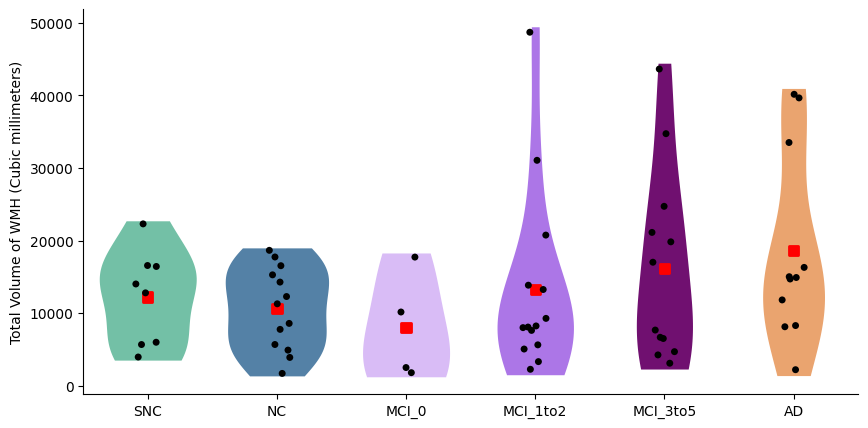

In [12]:
### get the OVER_group comoparison
wmh_wave2 = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='wave2')
wmh_wave2_codes = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='Sheet1')
colors = ["#66CDAA","#4682B4","#D9B3FF",  "#AB63FA", "#800080", "#FFA15A"]
wmh_wave2_codes['wmh_zscores'] = get_z_scores(wmh_wave2_codes['M_w2_total_wmh'])
keys = [ 'MCI_1to2','MCI_3to5']
# keys = ['MCI_0']
OVER_group = wmh_wave2_codes[wmh_wave2_codes['subgroups_1_1'].isin(keys)]['caseid']

yy = 'M_w2_total_wmh'

figure = plt.figure(figsize=(10, 5))
ax = figure.add_subplot(111)
sns.violinplot(x='subgroups_1_2', y=yy, data=wmh_wave2_codes, ax=ax, inner=None, palette=colors,linewidth=0,
               order=['SNC','NC','MCI_0','MCI_1to2','MCI_3to5', 'AD'], cut=0.1)
sns.stripplot(x='subgroups_1_2', y=yy, data=wmh_wave2_codes, palette=['black'],
             jitter=True, dodge=True, ax=ax, order=['SNC','NC','MCI_0','MCI_1to2','MCI_3to5', 'AD'])
sns.pointplot(x = 'subgroups_1_2', y=yy, data=wmh_wave2_codes, estimator=np.mean, color="red", ci = None, join=False, markers='s',
              order=['SNC','NC','MCI_0','MCI_1to2','MCI_3to5', 'AD'])


plt.xlabel('')
plt.ylabel('Total Volume of WMH (Cubic millimeters)')
# hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

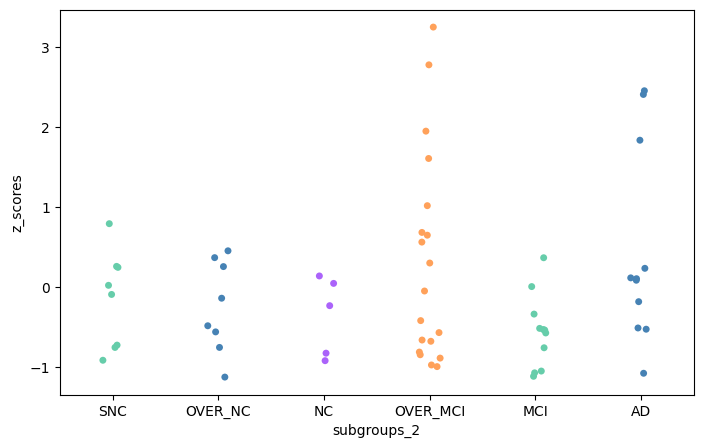

In [13]:
datas = pd.read_excel('/Users/yilewang/workspaces/data4project/MAS_T2w/waves_wmh.xlsx', sheet_name='Sheet1')
# ignore values in #N/A in datas
z_scores = get_z_scores(datas['M_w2_total_wmh'])
datas['z_scores'] = z_scores
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
# plot the distribution of each column in the pd_quadratic_zscors
i = 'z_scores'
figure = plt.figure(figsize=(18,5))
ax1 = figure.add_subplot(121)
# plot distribution of the z-scores
# sns.violinplot(data = datas, y=i, x='OVER', ax=ax1)
sns.stripplot(data = datas, y=i, x='subgroups_2', ax=ax1, jitter=True, dodge=True, palette=colors)
plt.show()

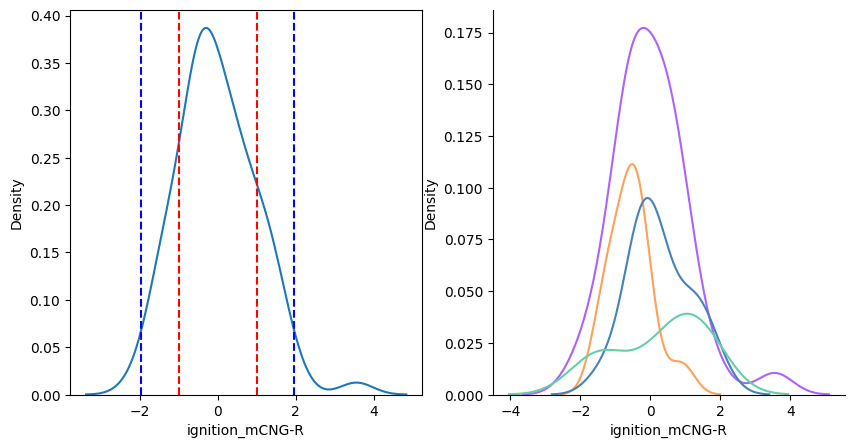

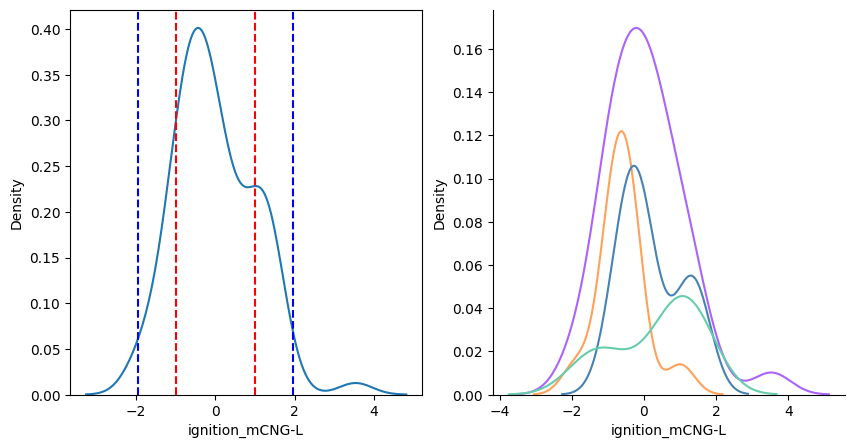

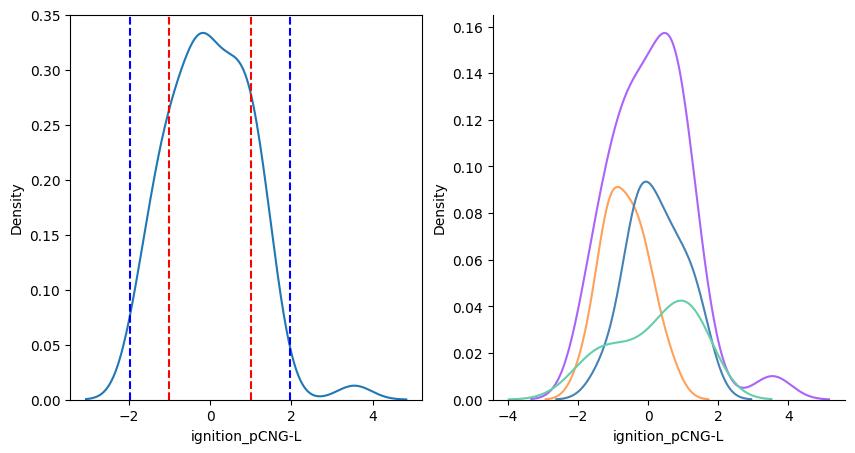

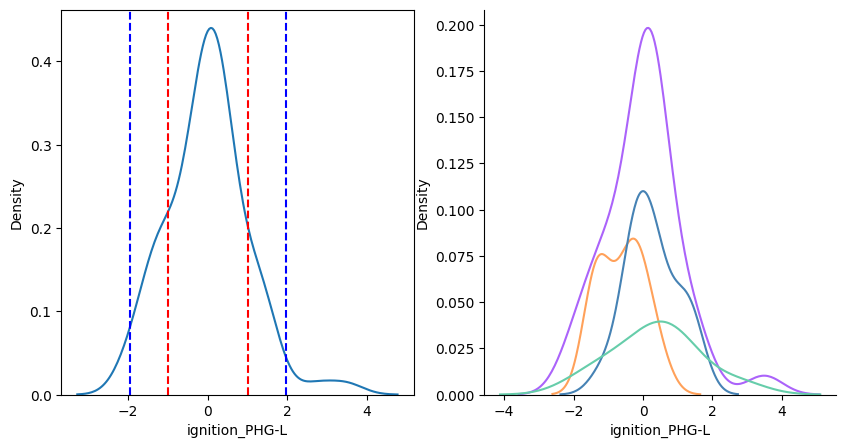

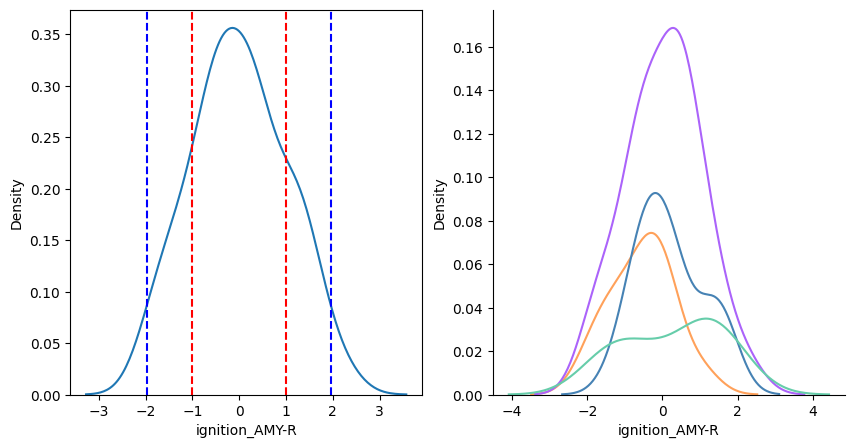

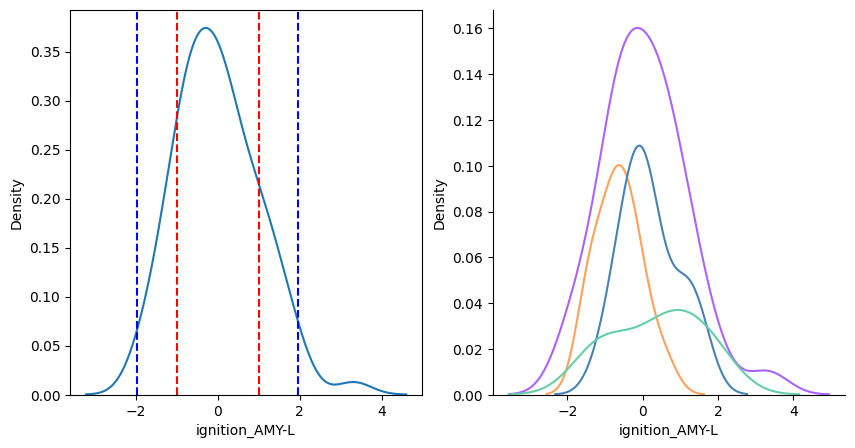

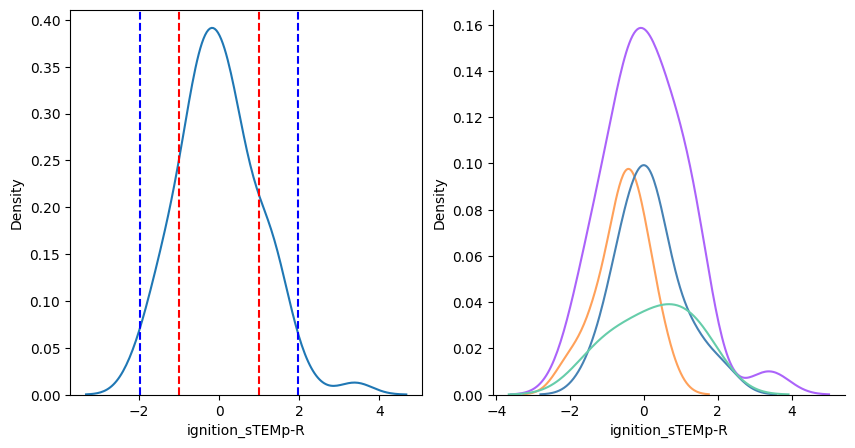

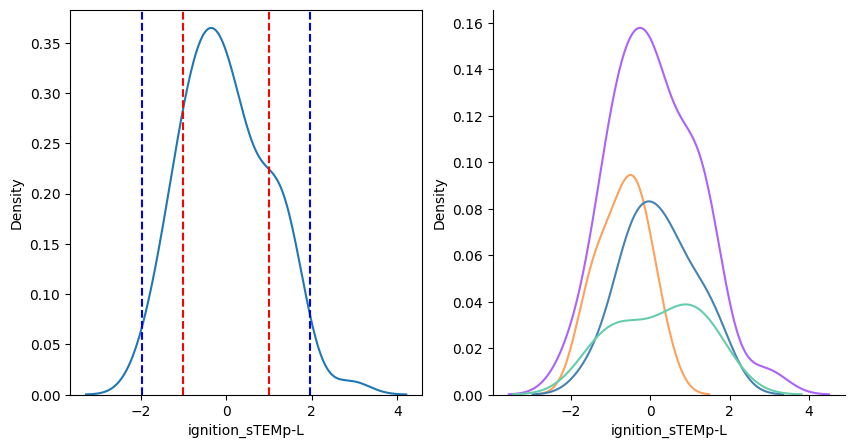

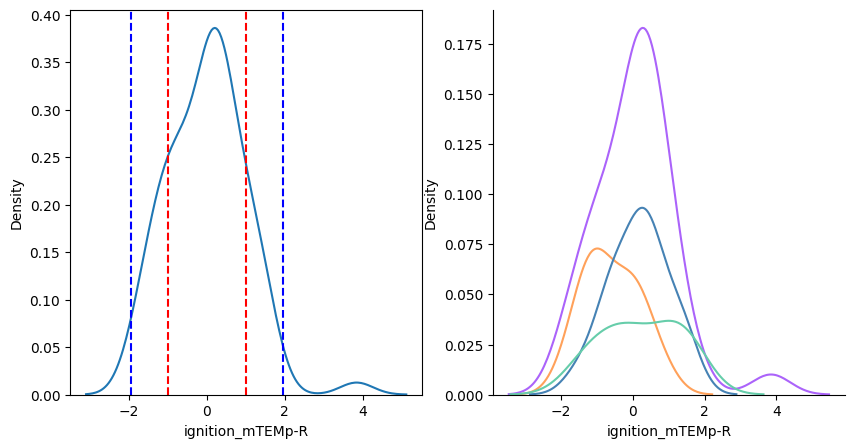

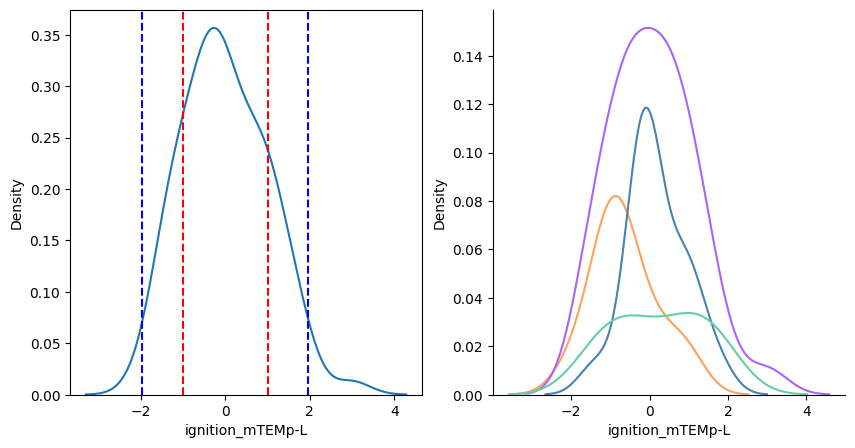

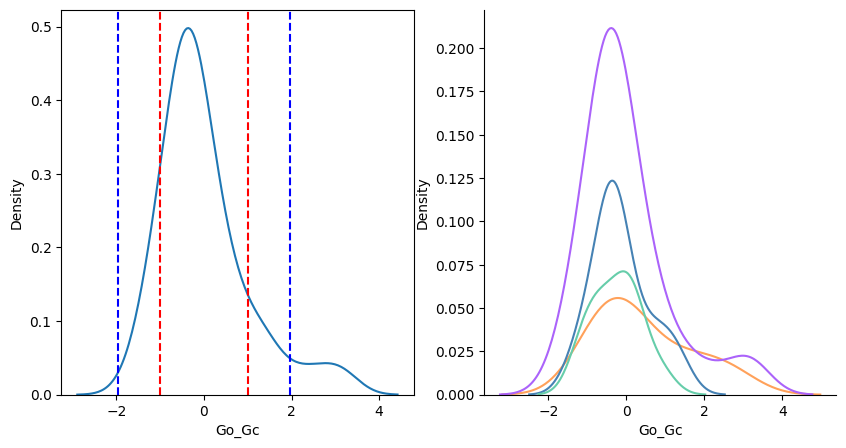

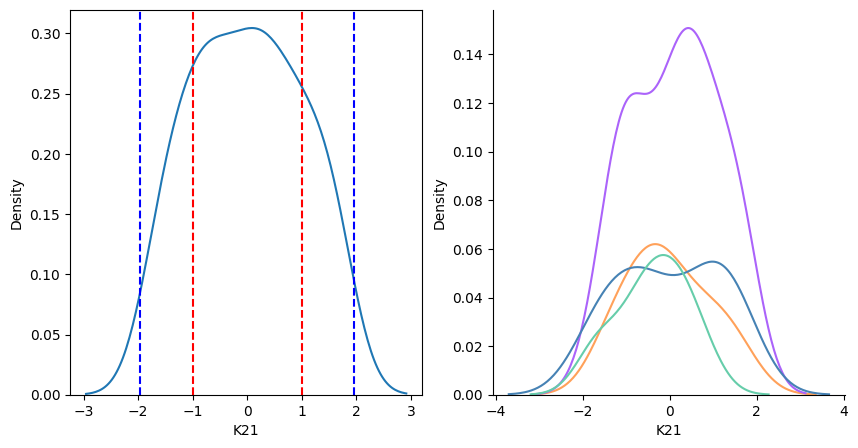

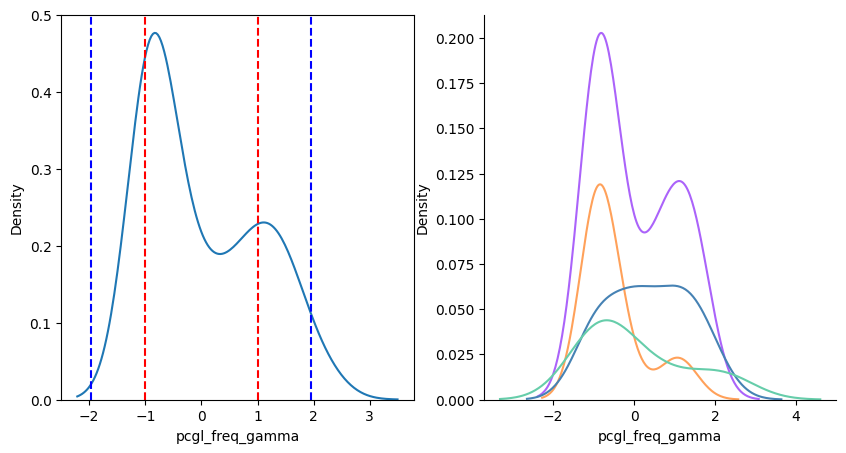

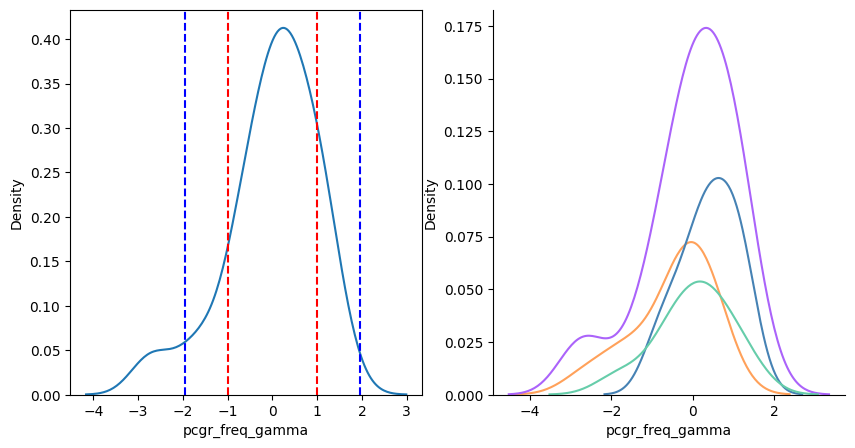

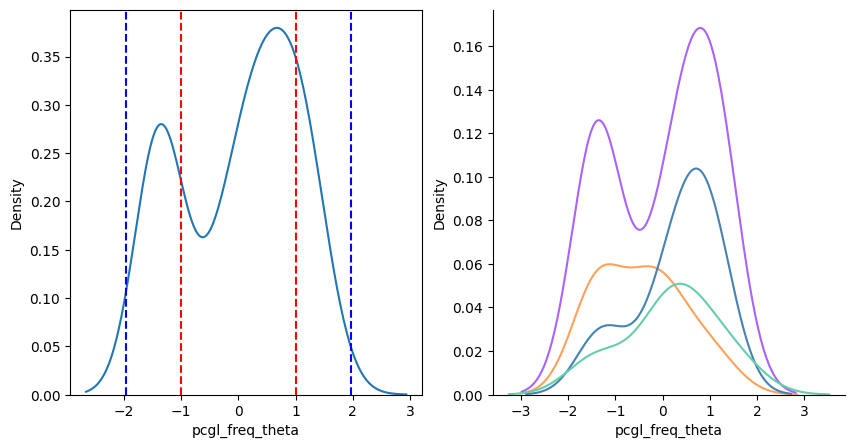

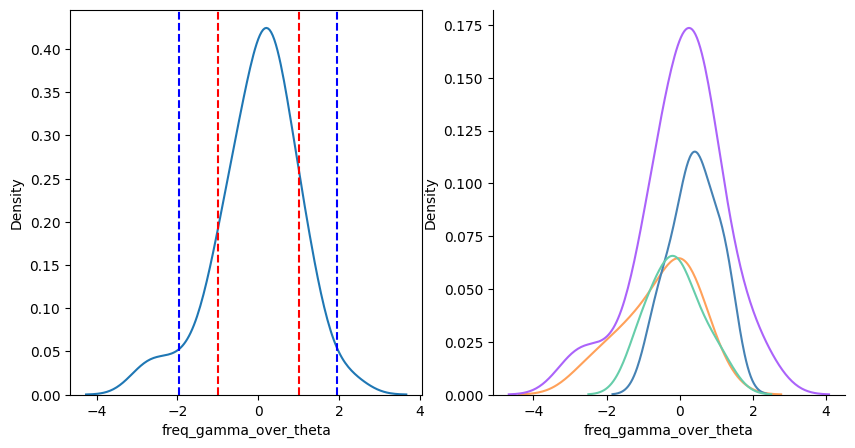

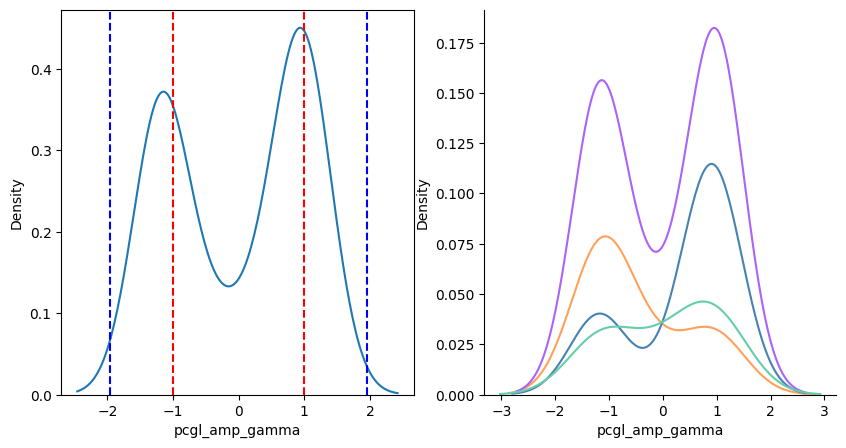

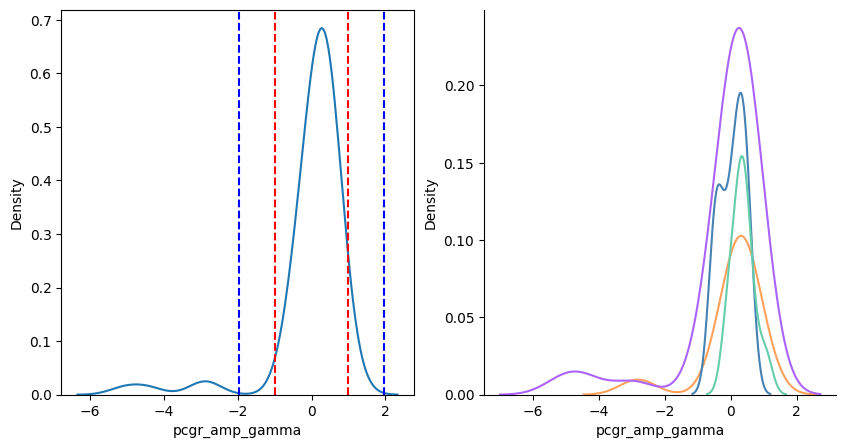

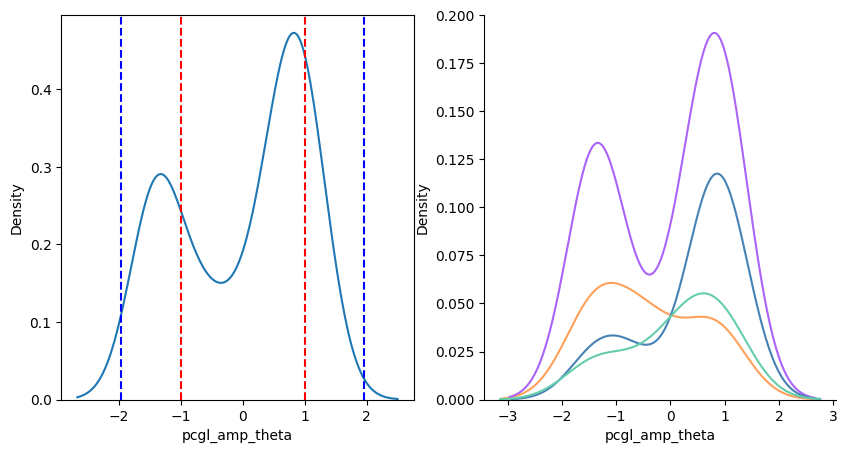

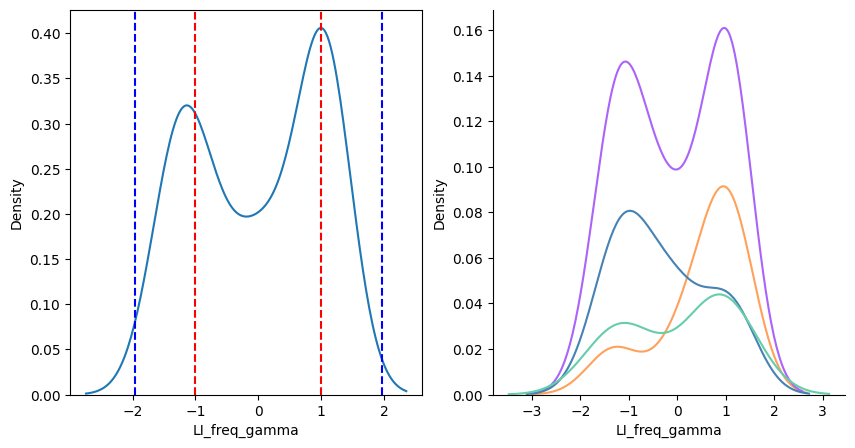

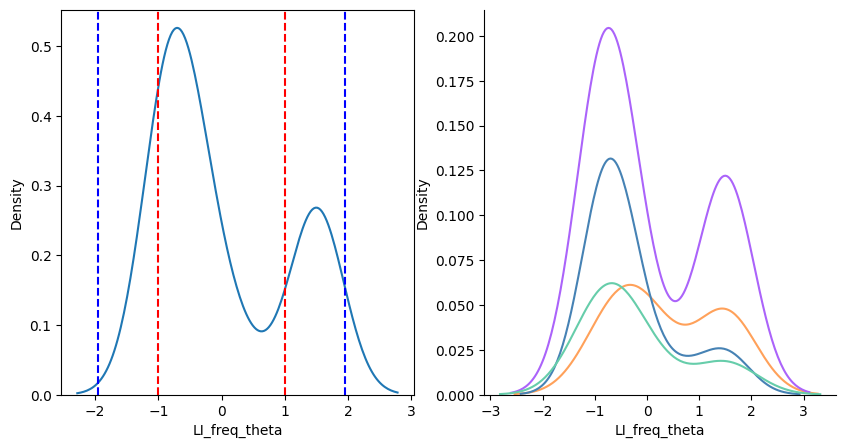

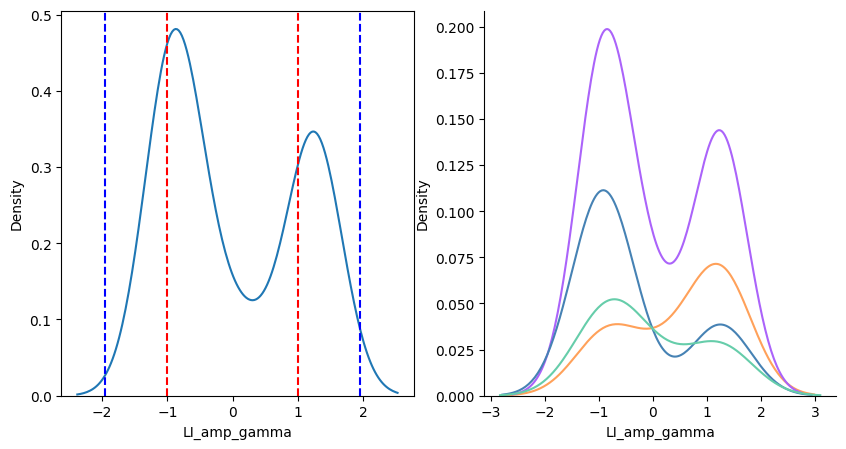

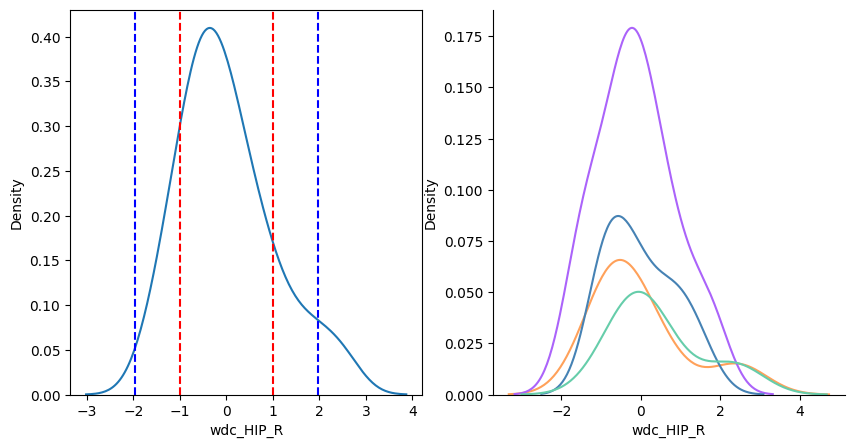

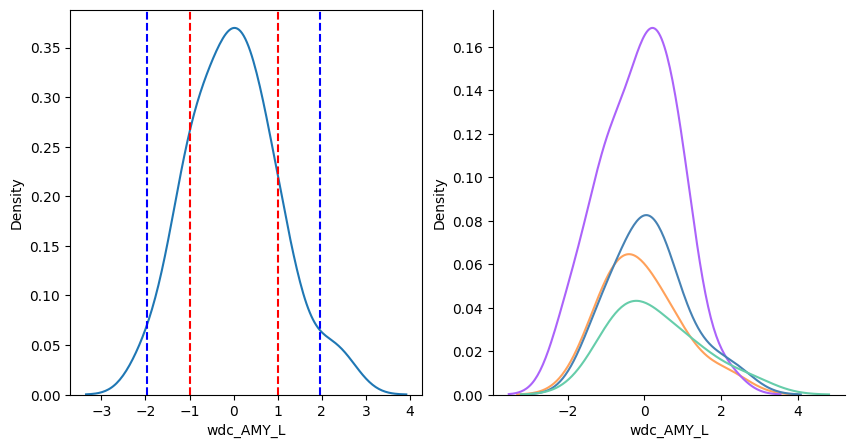

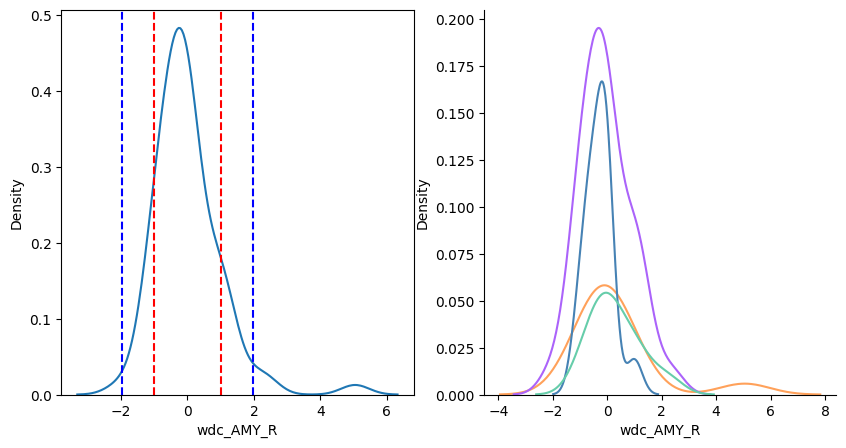

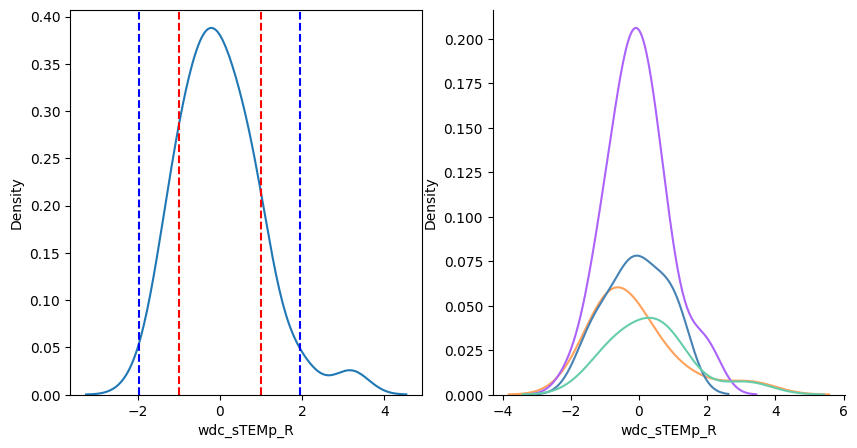

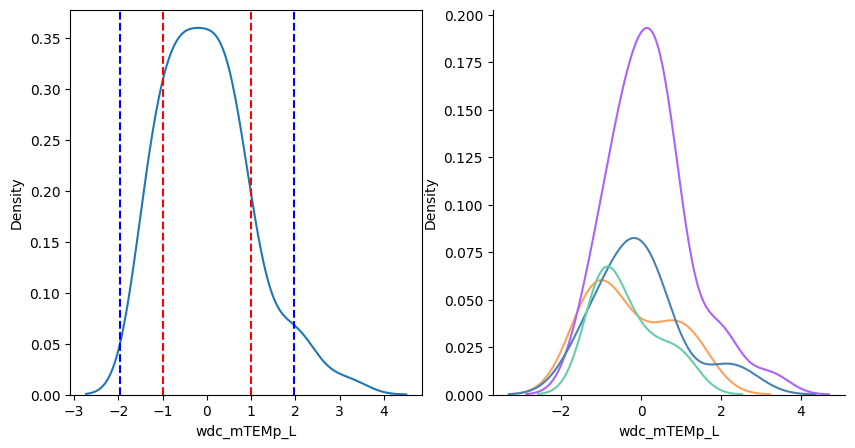

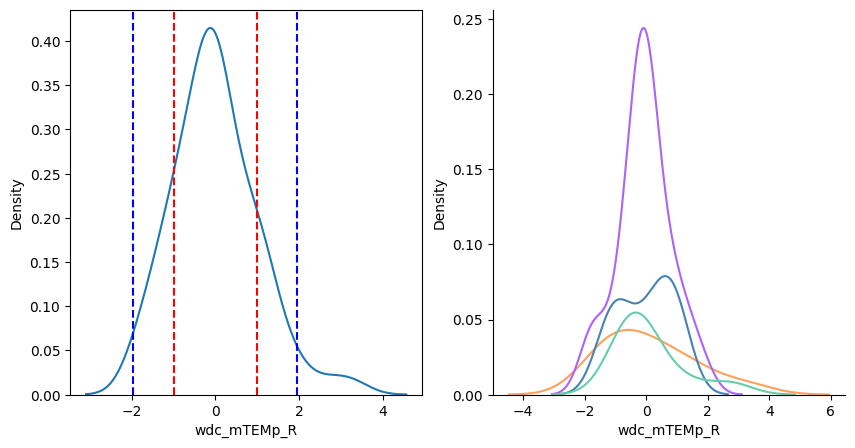

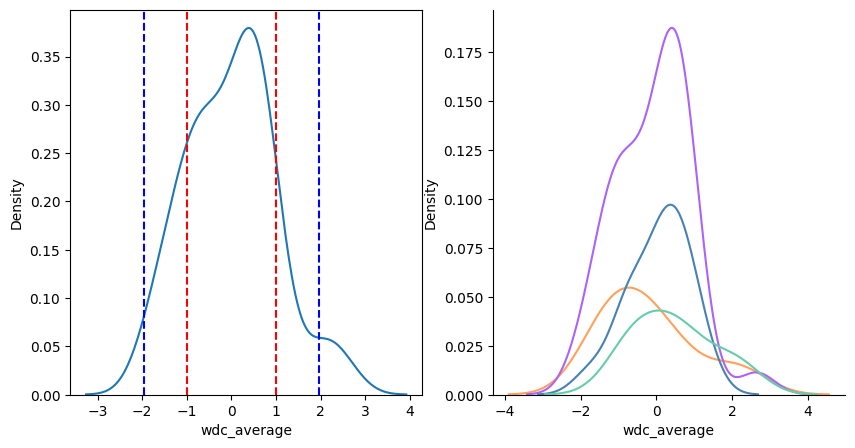

In [19]:
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
# plot the distribution of each column in the pd_quadratic_zscors
for i in pd_quadratic_zscors.columns[3:]:
    figure = plt.figure(figsize=(10,5))
    ax1 = figure.add_subplot(121)
    # plot distribution of the z-scores
    sns.kdeplot(data = pd_quadratic_zscors, x=i, ax=ax1)
    ax2 = figure.add_subplot(122)
    sns.kdeplot(data = pd_quadratic_zscors, x=i, hue='group', palette=colors, ax=ax2)
    # plot lines for 1 std 
    ax1.axvline(1., color='r', linestyle='--', label='1 std')
    ax1.axvline(-1., color='r', linestyle='--')
    # ax2.axvline(1., color='r', linestyle='--')
    # ax2.axvline(-1., color='r', linestyle='--')
    # and 2 std
    ax1.axvline(1.96, color='b', linestyle='--', label='2 std')
    ax1.axvline(-1.96, color='b', linestyle='--')
    # ax2.axvline(1.96, color='b', linestyle='--')
    # ax2.axvline(-1.96, color='b', linestyle='--')
    # ax1.legend()
    # hide the legend
    # hide the right and top spines
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    plt.show()

In [15]:
### Visualization Module
for i in data.columns[5:]:
    figure = plt.figure(figsize=(15, 10))
    ax = figure.add_subplot(111)
    coordinates = stripplot_get_coordinates(data, 'group', i)
    ax.plot(coordinates[:,0], coordinates[:,1], 'o')
    texts = [plt.text(coordinates[:,0][i], coordinates[:,1][i], f'{group}_{caseid}', ha='center', va='center') for i, (group, caseid) in enumerate(zip(data['group'], data['caseid']))]

    # texts = [plt.text(coordinates[:,0][i], coordinates[:,1][i], f'{sex}_{group}_{caseid}', ha='center', va='center') for i, (group, caseid, sex) in enumerate(zip(data['group'], data['caseid'], data['M_Sex']))]
    adjust_text(texts, expand=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='->', color='red') # ensure the labeling is clear by adding arrows
            )
    plt.show()
    # Label the points with their y-offset (y_var)

KeyboardInterrupt: 

In [ ]:
### get prediction rank
data = pd_quadratic
def get_top_values_caseid(data, x_var, y_var):
    pd_single_rank = pd.DataFrame()
    # Sort the DataFrame
    sort_by = [by for by in [x_var, y_var] if by is not None]
    data_sort = data.sort_values(by=sort_by)[::-1]
    rank_within_group = []
    for i in data['group'].unique():
        #generate 1 to len(group) for each group
        rank = np.arange(1, len(data_sort[data_sort['group']==i])+1)
        rank_within_group.append(rank)
    # flatten the list
    rank_within_group = [item for sublist in rank_within_group for item in sublist]
    pd_single_rank['group'] = data_sort['group']
    pd_single_rank['caseid'] = data_sort['caseid']
    pd_single_rank[y_var] = rank_within_group
    return pd_single_rank


df_rank_list = pd.DataFrame({'group': data['group'], 'caseid': data['caseid']})
for i in data.columns[2:]:
    tmp_pd = get_top_values_caseid(data, 'group', i)
    merged_df = df_rank_list.merge(tmp_pd, on='caseid', how='left')
    df_rank_list[i] = merged_df[i]
    
df_rank_list.to_excel('/Users/yilewang/workspaces/data4project/prediction_rank.xlsx', sheet_name='rank', index=False)